# Article Classification using Clustering

We need to perform Document Clustering according to the genres of the documents and try to optimise the clustering. There are various types of clustering algorithms:
1. K-Means Clustering
2. Document Based Spatial Clustering of Applications with Noise
3. Hierarchical Clustering - Agglomerative and Divisive

We would try and apply these algorithms on our data and try to achieve a good clustering.

Metric for evaluation of clustering: **Silhouette Score** and **Calinski-Harabasz Index**

## Part 1: Import the required libraries and get the dataset ready

In [3]:
!pip install texthero
!pip install spacy -U

     |████████████████████████████████| 10.4 MB 778 kB/s            
     |████████████████████████████████| 1.5 MB 52.4 MB/s            
     |████████████████████████████████| 24.2 MB 23.4 MB/s            
     |████████████████████████████████| 1.0 MB 54.7 MB/s            
     |████████████████████████████████| 184 kB 63.9 MB/s            
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.2
    Uninstalling srsly-2.4.2:
      Successfully uninstalled srsly-2.4.2
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.6
    Uninstalling catalogue-2.0.6:
      Successfully uninstalled catalogue-2.0.6
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.15
    Uninstalling thinc-8.0.15:
      Successfully uninstalled thinc-8.0.15
  Attempting uninstall: spacy
    Found existing installation: spacy 3.2.3
    Uninstalling spacy-3.2.3:
      Successfully uninstalled spacy-3.2.3
  Attempting uninstall: nltk
    Found exis

In [4]:
#importing the required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import texthero as hero
import nltk
import re

In [5]:
# form a dataframe with the given articles
FILE_PATH = "../input/article-classification-assignment/dataset"
Title = []
Text = []

files = os.listdir(FILE_PATH)

for file in files:
    with open(FILE_PATH+'/'+file,encoding = 'unicode_escape') as f:
        data = f.read()
        x = data.split('\n\n')
        Text.append(x[1])
        Title.append(x[0])
        
df = pd.DataFrame({'Title':Title, 'Text':Text})
df.head()

Title  \
0  Steady job growth continues in US   
1   GSK aims to stop Aids profiteers   
2    Games firms 'face tough future'   
3   Tory candidate quits over remark   
4  Global digital divide 'narrowing'   

                                                Text  
0  The US created fewer jobs than expected in Dec...  
1  One of the world's largest manufacturers of HI...  
2  UK video game firms face a testing time as the...  
3  A Conservative election challenger is quitting...  
4  The "digital divide" between rich and poor nat...

## Part 2: Text Preprocessing

In [6]:
df['Text'].value_counts()

The US created fewer jobs than expected in December, but analysts said that the dip in hiring was not enough to derail the world's biggest economy.     2
The European Parliament has thrown out a bill that would have allowed software to be patented.                                                          2
Mobile phones in the UK are celebrating their 20th anniversary this weekend.                                                                            2
New York electro-rock group The Bravery have come top of the BBC News website's Sound of 2005 poll to find the music scene's most promising new act.    2
People using wireless net hotspots will soon be able to make free phone calls as well as surf the net.                                                  2
                                                                                                                                                       ..
Parmalat, the Italian food group at the centre of one of Europe's most painf

As we can see from the results of **value_counts()**, there are duplicates datapoints in our dataset. So we need to drop the duplicates.

In [7]:
# drop the duplicates
print(df.shape)
df.drop_duplicates(keep='first',inplace=True)
print(df.shape)

(2225, 2)
(2105, 2)


Now we will use the **texthero** library for easy preprocessing of the text in our dataset. This involves:
1. Removal of stopwords
2. Removal of whitespaces
3. Filling of NaN value rows
4. Turning all to lower_case

In [8]:
from texthero import preprocessing as ppe
custom_pipeline = [ ppe.fillna, ppe.lowercase, ppe.remove_whitespace,ppe.remove_stopwords,ppe.remove_html_tags]
df['Title'] = hero.clean(df['Title'], custom_pipeline)
df['Text'] = hero.clean(df['Text'], custom_pipeline)

In [10]:
df['Text'][0]

" us created fewer jobs  expected  december,  analysts said   dip  hiring   enough  derail  world' biggest economy."

Next we use the **nltk** library for *Stemming* the texts and the titles

In [14]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
ps = PorterStemmer()

for idx in range(len(df)):
    sentence = df['Text'][0]
    final_sentence = []
    word_tokens = word_tokenize(sentence)
    for w in word_tokens:
        final_sentence.append(ps.stem(w))
    df['Text'][idx] = " ".join(final_sentence)

df['Text'][0]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


"us creat fewer job expect decemb , analyst said dip hire enough derail world ' biggest economi ."

## Part 3: Applying K-Means Clustering Algorithm
I have decided to apply the K-Means Clustering in two ways:
1. By considering the BOW from 'Text' only
2. By considering the BOW from 'Title' and 'Text'

In [15]:
# form bag of words from text only
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
vec1 = cv.fit_transform(df['Text'].values)
vec1.shape

(2105, 1162)

In [16]:
# number of clusters to check.
num_clus = [x for x in range(3,11)]

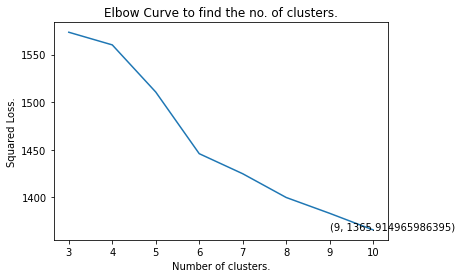

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  1365.914965986395


In [17]:
# K-Means Considering text only
from sklearn.cluster import KMeans
squared_loss = []
for num in num_clus:
    model = KMeans(n_clusters = num,init='k-means++',random_state=99)
    model.fit(vec1)
    squared_loss.append(model.inertia_)

optimal_clusters = np.argmin(squared_loss)+2
plt.plot(num_clus, squared_loss)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_loss))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_loss))

In [31]:
model = KMeans(n_clusters = 9, init='k-means++',random_state=99)
model.fit(vec1)
df['Cluster'] = model.labels_

In [32]:
# evaluation metrics
# Silhouette Score
from sklearn import metrics
silhouette_score = metrics.silhouette_score(vec1, model.labels_, metric='euclidean')
print('Silhouette Score = ',silhouette_score)
# Calinski-Harabasz Index
ch_index = metrics.calinski_harabasz_score(vec1.toarray(), model.labels_)
print('Calinski-Harabasz Index = ',ch_index)

Silhouette Score =  0.9489738974142188
Calinski-Harabasz Index =  339.95015893874637


In [33]:
df.head()

Title  \
0    steady job growth continues  us   
1     gsk aims  stop aids profiteers   
2    games firms 'face tough future'   
3       tory candidate quits  remark   
4  global digital divide 'narrowing'   

                                                Text  Cluster  
0  us creat fewer job expect decemb , analyst sai...        0  
1  us creat fewer job expect decemb , analyst sai...        0  
2  us creat fewer job expect decemb , analyst sai...        0  
3  us creat fewer job expect decemb , analyst sai...        0  
4  us creat fewer job expect decemb , analyst sai...        0

In [34]:
df.groupby(['Cluster'])['Text'].count()

Cluster
0    1996
1       3
2       1
3     100
4       1
5       1
6       1
7       1
8       1
Name: Text, dtype: int64

As we can see, the clustering does not seem to be very appropriate as there is only 1 label in 6 clusters out of 9 and one cluster has 1996 labels. Next we move to K-Means Clustering with BOW from both text and title.

In [35]:
# form bag of words from text and title
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
vec2 = cv.fit_transform(df['Text'].values+df['Title'].values)
vec2.shape

(2105, 4184)

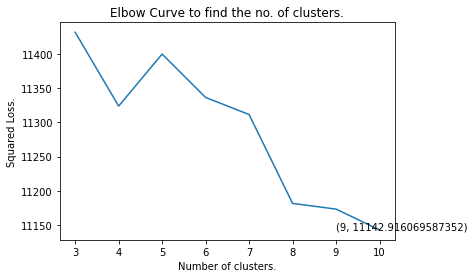

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  11142.916069587352


In [36]:
# K-Means Considering text and title
from sklearn.cluster import KMeans
squared_loss = []
for num in num_clus:
    model = KMeans(n_clusters = num,init='k-means++',random_state=99)
    model.fit(vec2)
    squared_loss.append(model.inertia_)

optimal_clusters = np.argmin(squared_loss)+2
plt.plot(num_clus, squared_loss)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_loss))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_loss))

In [37]:
model = KMeans(n_clusters = 9, init='k-means++',random_state=99)
model.fit(vec2)
df['Cluster 2'] = model.labels_

In [38]:
# evaluation metrics
# Silhouette Score
from sklearn import metrics
silhouette_score = metrics.silhouette_score(vec2, model.labels_, metric='euclidean')
print('Silhouette Score = ',silhouette_score)
# Calinski-Harabasz Index
ch_index = metrics.calinski_harabasz_score(vec2.toarray(), model.labels_)
print('Calinski-Harabasz Index = ',ch_index)

Silhouette Score =  -0.005771369722103424
Calinski-Harabasz Index =  44.79597011530403


In [40]:
df.groupby(['Cluster 2'])['Text'].count()

Cluster 2
0      32
1     103
2    1842
3     106
4      16
5       1
6       1
7       1
8       3
Name: Text, dtype: int64

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Wordcloud for category #0


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


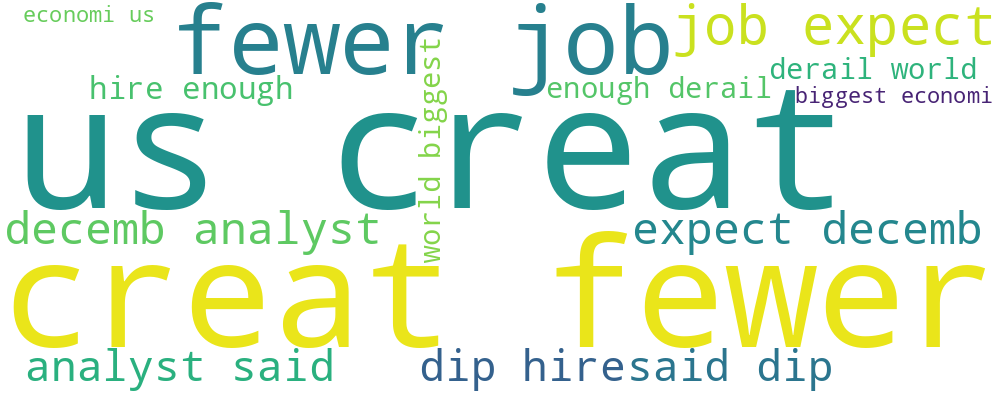

Wordcloud for category #1


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


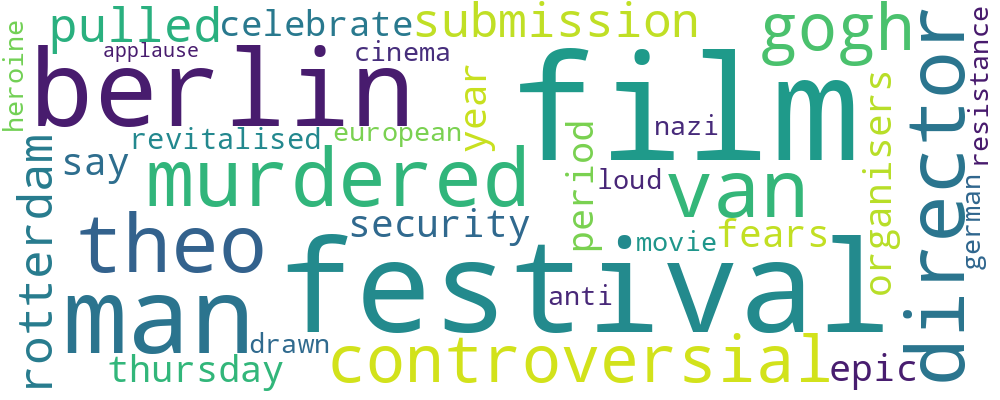

Wordcloud for category #2


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


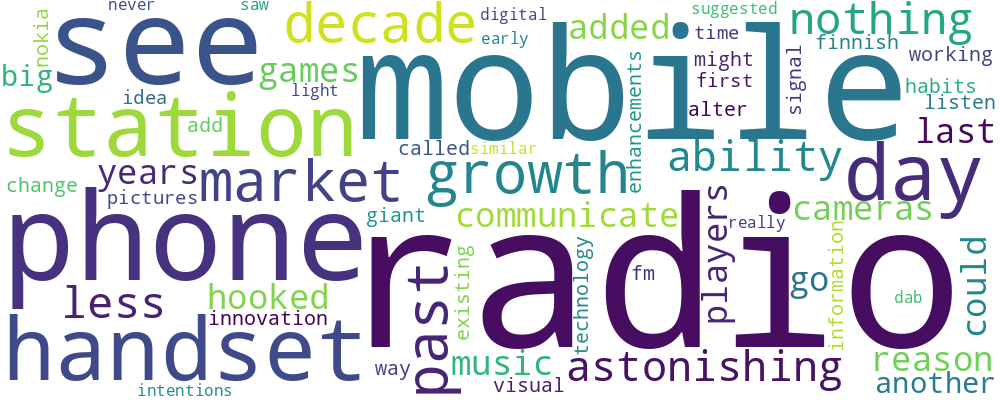

Wordcloud for category #3


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


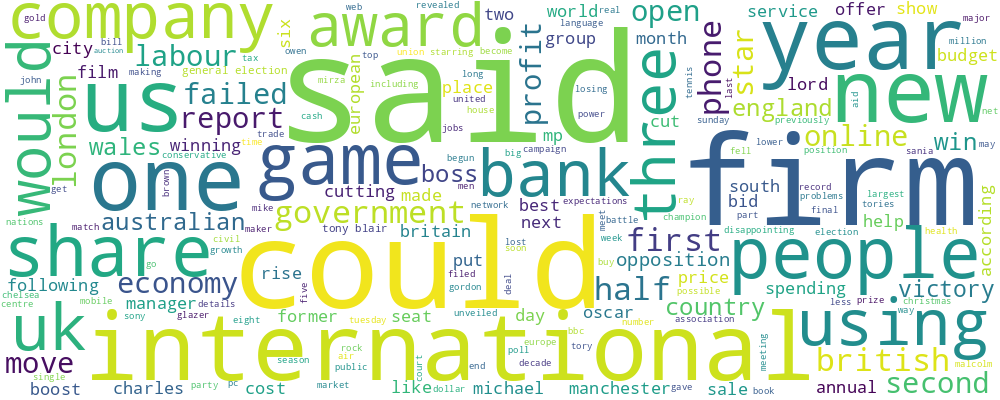

Wordcloud for category #4


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


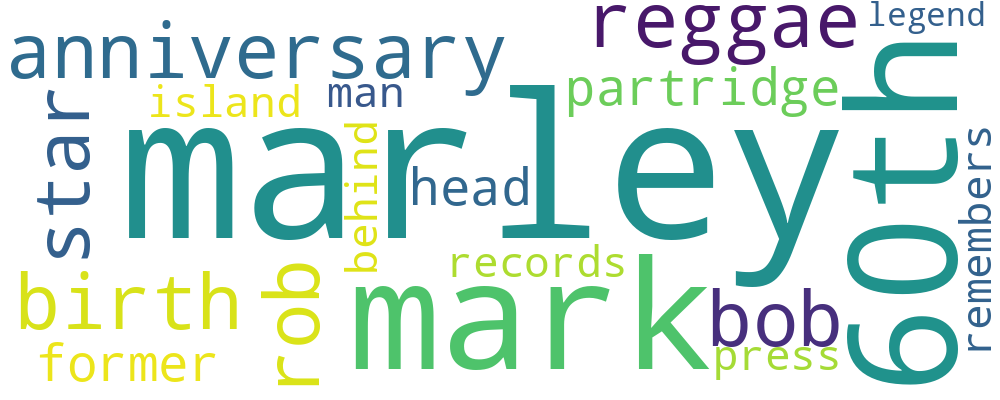

Wordcloud for category #5


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


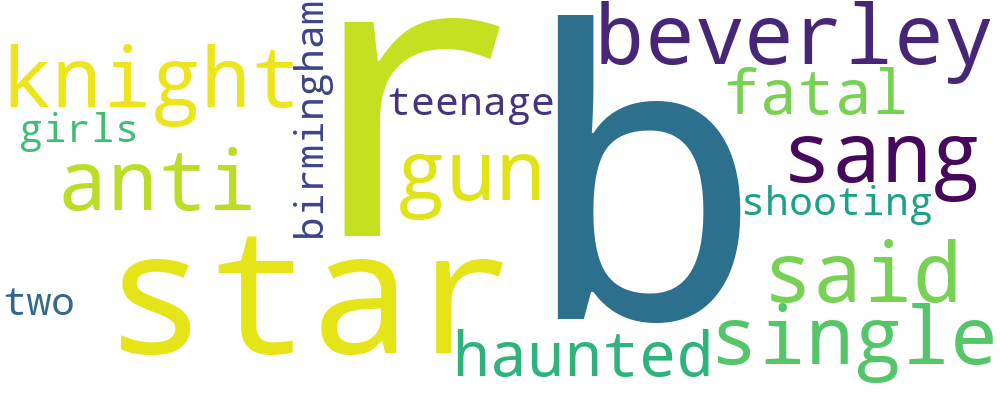

Wordcloud for category #6


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


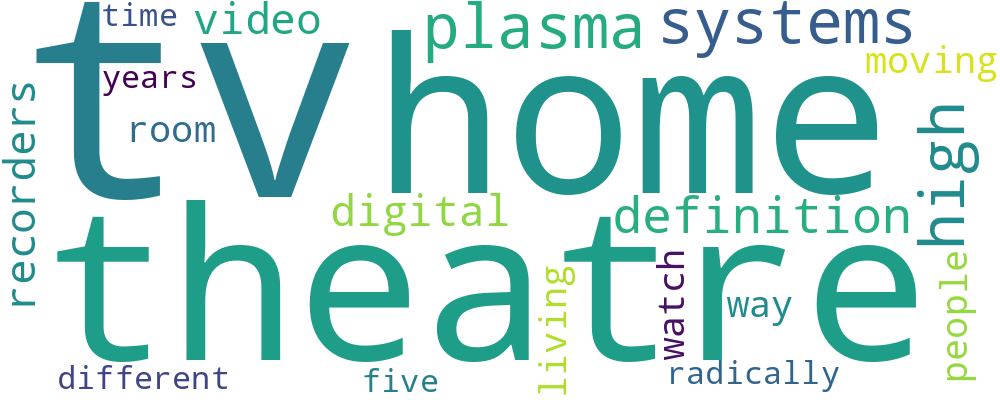

Wordcloud for category #7


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


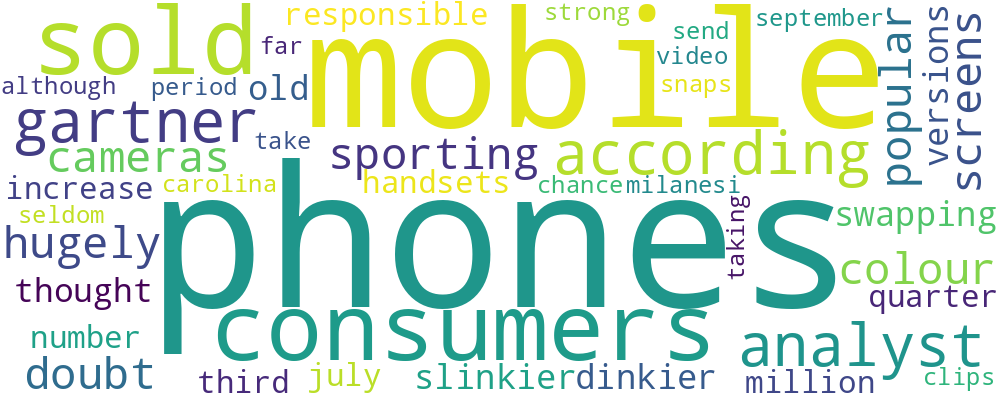

Wordcloud for category #8


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


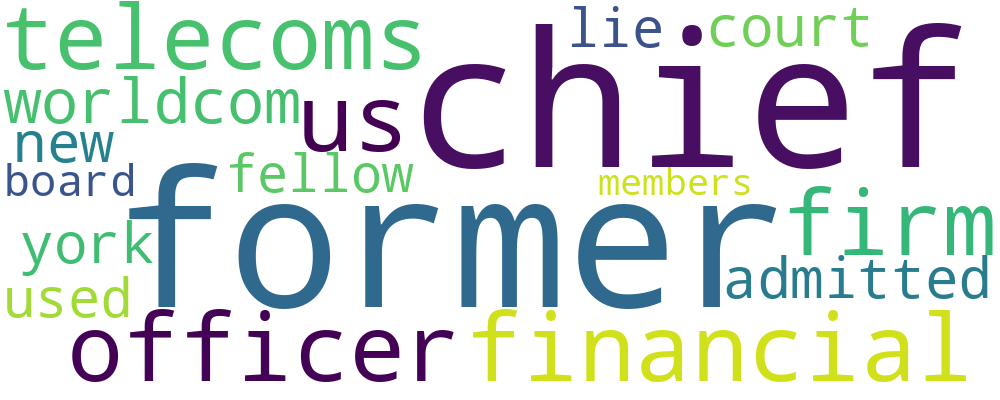

In [46]:
#visualisation of top words for the K-Means with text only
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=1000, height=400, stopwords=[])

for c in range(9):
    print("Wordcloud for category #{}".format(c))
    sentence = " ".join(df['Text'][df['Cluster'] == c])
    tokens = nltk.word_tokenize(sentence)
    pos_tagged_tokens = nltk.pos_tag(tokens)
    list_of_verbs = []
    for i in range(len(pos_tagged_tokens)):
        if pos_tagged_tokens[i][1] == 'VBZ':
            list_of_verbs.append(pos_tagged_tokens[i][0])
    
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(list_of_verbs)
    
    filtered_sentence = [w for w in tokens if not w.lower() in stopwords]
    
    final_sentence = " ".join(filtered_sentence)
    display(wc.generate(final_sentence).to_image())

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wordcloud for category #0


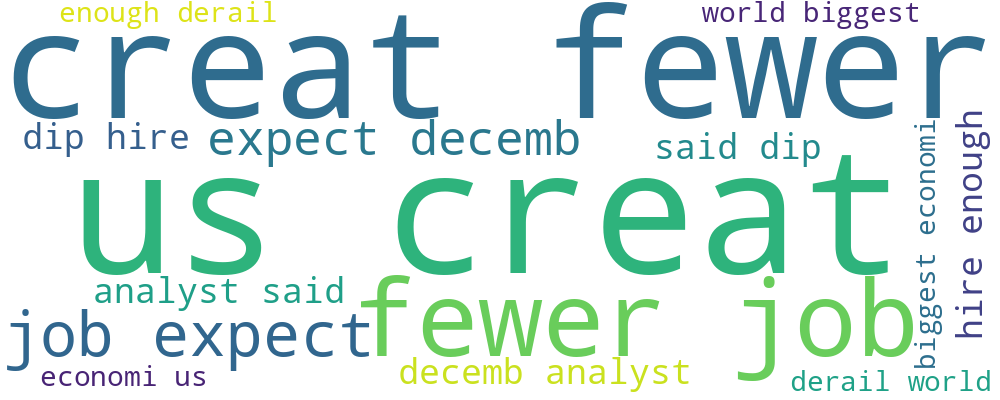

Wordcloud for category #1


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


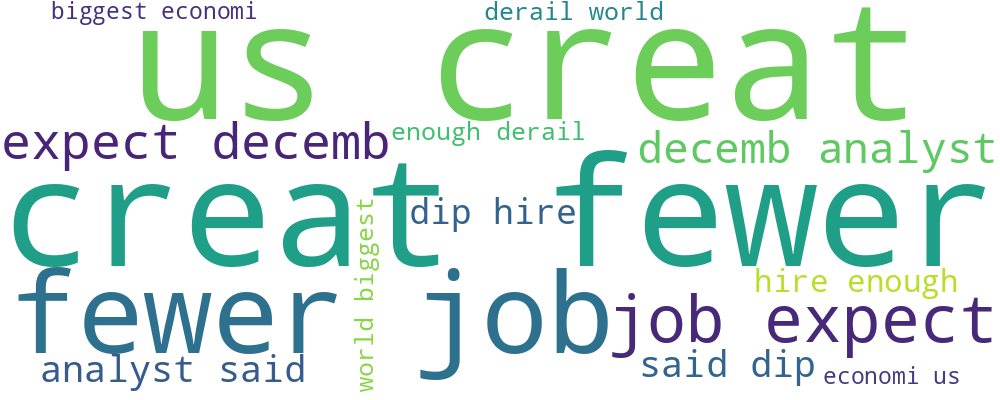

Wordcloud for category #2


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


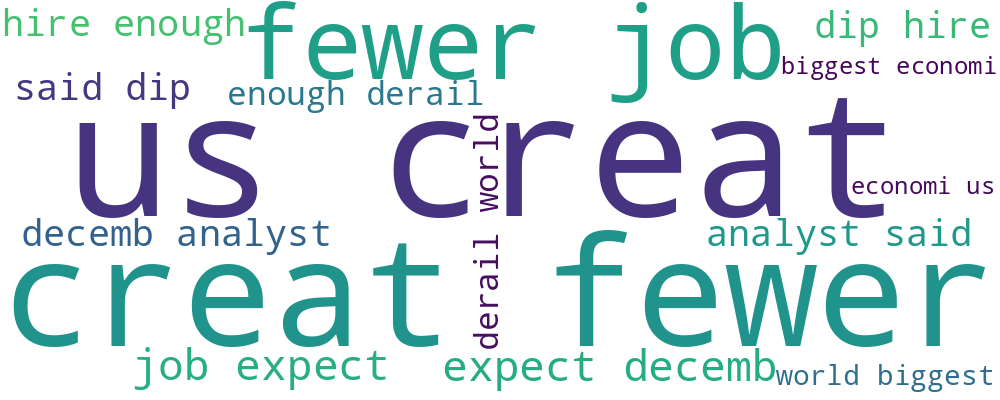

Wordcloud for category #3


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


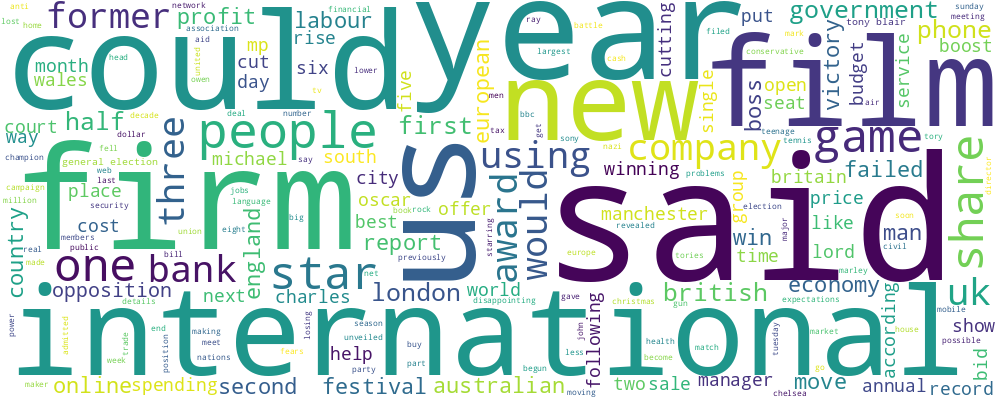

Wordcloud for category #4


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


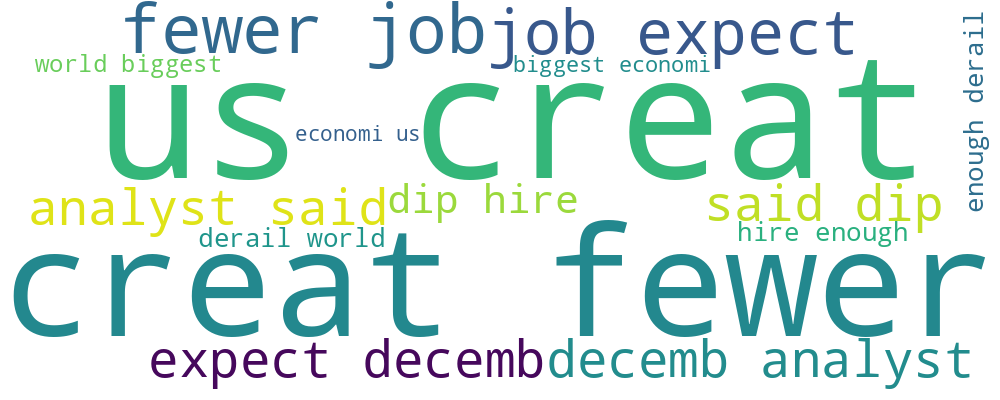

Wordcloud for category #5


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


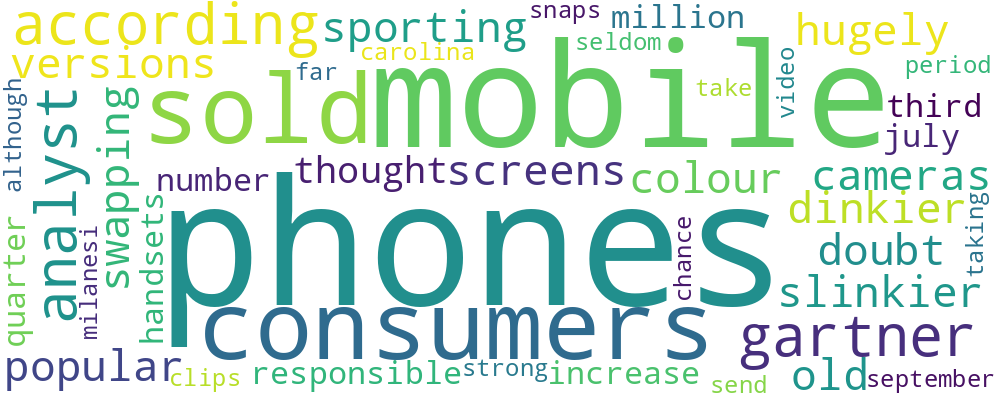

Wordcloud for category #6


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


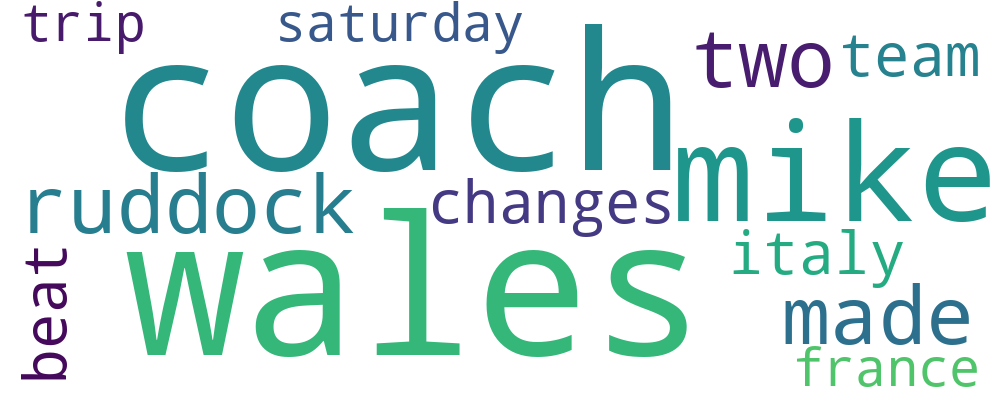

Wordcloud for category #7


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


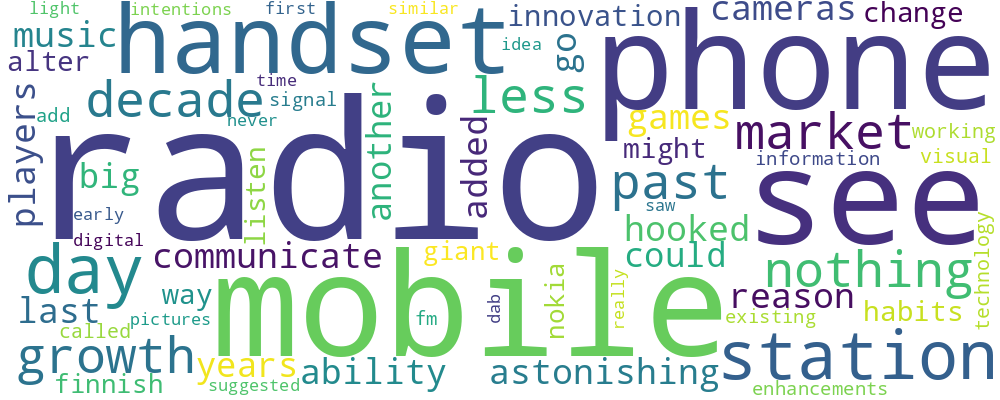

Wordcloud for category #8


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


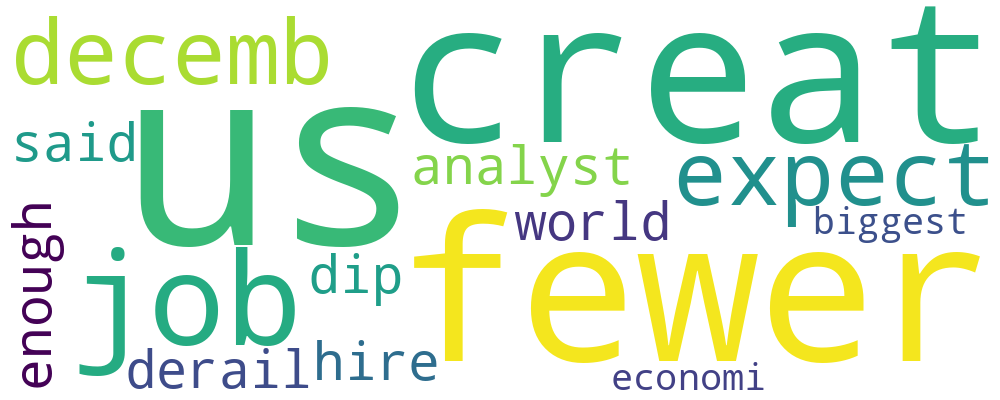

In [47]:
#visualisation of top words for the K-Means with text and title
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=1000, height=400, stopwords=[])

for c in range(9):
    print("Wordcloud for category #{}".format(c))
    sentence = " ".join(df['Text'][df['Cluster 2'] == c])
    tokens = nltk.word_tokenize(sentence)
    pos_tagged_tokens = nltk.pos_tag(tokens)
    list_of_verbs = []
    for i in range(len(pos_tagged_tokens)):
        if pos_tagged_tokens[i][1] == 'VBZ':
            list_of_verbs.append(pos_tagged_tokens[i][0])
    
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(list_of_verbs)
    
    filtered_sentence = [w for w in tokens if not w.lower() in stopwords]
    
    final_sentence = " ".join(filtered_sentence)
    display(wc.generate(final_sentence).to_image())

We can see that the results are becoming even worse(negative silhouette score and low CH Index) when we consider both the text and title together.

## Part 4: Applying DBSCAN Algorithm

In [41]:
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=3,min_samples=4,metric='euclidean')
db.fit(vec1)
df['Cluster 3'] = db.labels_

In [43]:
# evaluation metrics
# Silhouette Score
from sklearn import metrics
silhouette_score = metrics.silhouette_score(vec1, db.labels_, metric='euclidean')
print('Silhouette Score = ',silhouette_score)
# Calinski-Harabasz Index
ch_index = metrics.calinski_harabasz_score(vec1.toarray(), db.labels_)
print('Calinski-Harabasz Index = ',ch_index)

Silhouette Score =  0.9481540825911168
Calinski-Harabasz Index =  1961.3746776891046


In [45]:
df.groupby(['Cluster 3'])['Text'].count()

Cluster 3
-1     109
 0    1996
Name: Text, dtype: int64

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wordcloud for category #-1


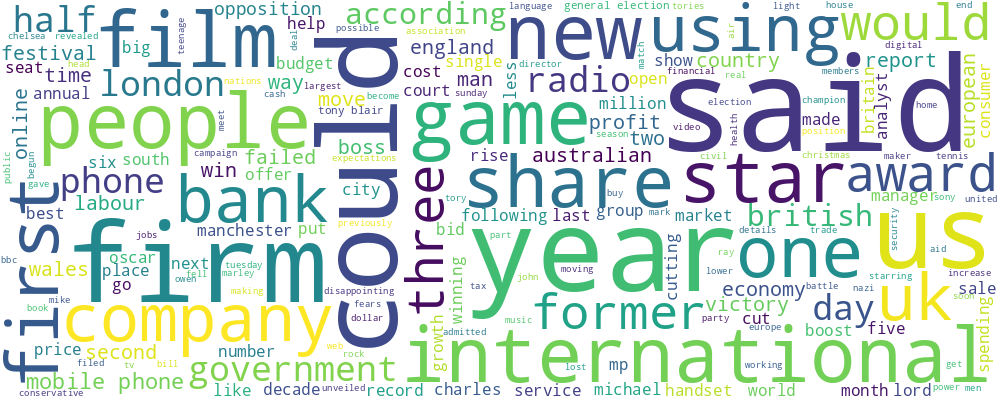

Wordcloud for category #0


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


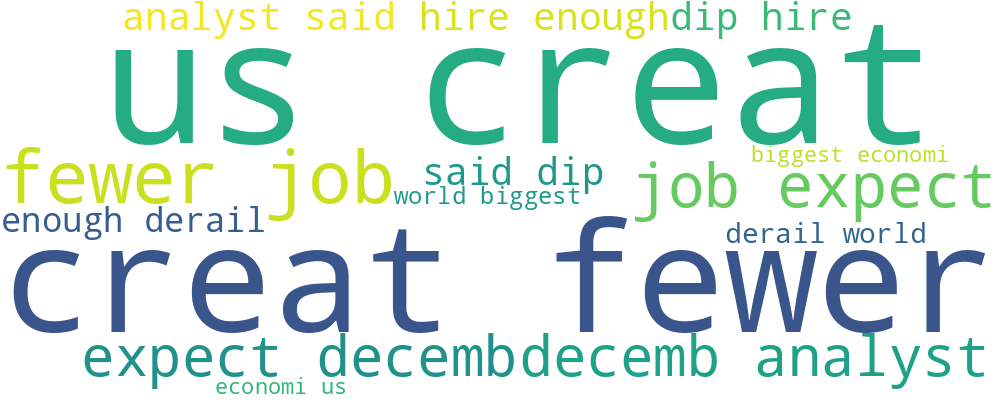

In [50]:
#visualisation of top words for the DBSCAN with text only
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=1000, height=400, stopwords=[])

for c in [-1,0]:
    print("Wordcloud for category #{}".format(c))
    sentence = " ".join(df['Text'][df['Cluster 3'] == c])
    tokens = nltk.word_tokenize(sentence)
    pos_tagged_tokens = nltk.pos_tag(tokens)
    list_of_verbs = []
    for i in range(len(pos_tagged_tokens)):
        if pos_tagged_tokens[i][1] == 'VBZ':
            list_of_verbs.append(pos_tagged_tokens[i][0])
    
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(list_of_verbs)
    
    filtered_sentence = [w for w in tokens if not w.lower() in stopwords]
    
    final_sentence = " ".join(filtered_sentence)
    display(wc.generate(final_sentence).to_image())

## Part 5: Creating Custom Sentence Vectors

In [55]:
# Train own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in df['Text'].values:
    list_of_sent.append(sent.split())

In [56]:
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [57]:
i=0
list_of_sent_train=[]
for sent in df['Text'].values:
    filtered_sentence=[]
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [58]:
import gensim
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent_train,size=100, workers=4)

In [59]:
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


(2105, 100)

## Part 6: Applying Agglomerative Hierarchical Clustering

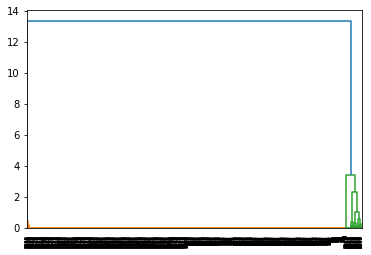

In [60]:
# generating the dendogram of the data
import scipy
from scipy.cluster import hierarchy
dendro=hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method='ward'))
plt.axhline(y=35)

In [61]:
# number of clusters = 5 from the dendogram plot above
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') 
Agg=cluster.fit_predict(sent_vectors)

In [62]:
df['Cluster 4'] = cluster.labels_
df.head()

Title  \
0    steady job growth continues  us   
1     gsk aims  stop aids profiteers   
2    games firms 'face tough future'   
3       tory candidate quits  remark   
4  global digital divide 'narrowing'   

                                                Text  Cluster  Cluster 2  \
0  us creat fewer job expect decemb , analyst sai...        0          1   
1  us creat fewer job expect decemb , analyst sai...        0          2   
2  us creat fewer job expect decemb , analyst sai...        0          2   
3  us creat fewer job expect decemb , analyst sai...        0          4   
4  us creat fewer job expect decemb , analyst sai...        0          2   

   Cluster 3  Cluster 4  
0          0          1  
1          0          1  
2          0          1  
3          0          1  
4          0          1

In [63]:
df.groupby(['Cluster 4'])['Text'].count()

Cluster 4
0      30
1    2007
2      30
3      19
4      19
Name: Text, dtype: int64

In [65]:
# evaluation metrics
# Silhouette Score
from sklearn import metrics
silhouette_score = metrics.silhouette_score(sent_vectors, cluster.labels_, metric='euclidean')
print('Silhouette Score = ',silhouette_score)
# Calinski-Harabasz Index
ch_index = metrics.calinski_harabasz_score(sent_vectors, cluster.labels_)
print('Calinski-Harabasz Index = ',ch_index)

Silhouette Score =  0.9814201480538265
Calinski-Harabasz Index =  87000.78190307638


As we can see, A very high Silhouette Score(almost equal to 1) is obtained, this shows that the clusters are very well separated and tightly bound. Also, the Calinski-Harabasz Index is very high(~87000) which shows that the within-cluster dispersion >> inbetween-cluster dispersion

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wordcloud for category #0


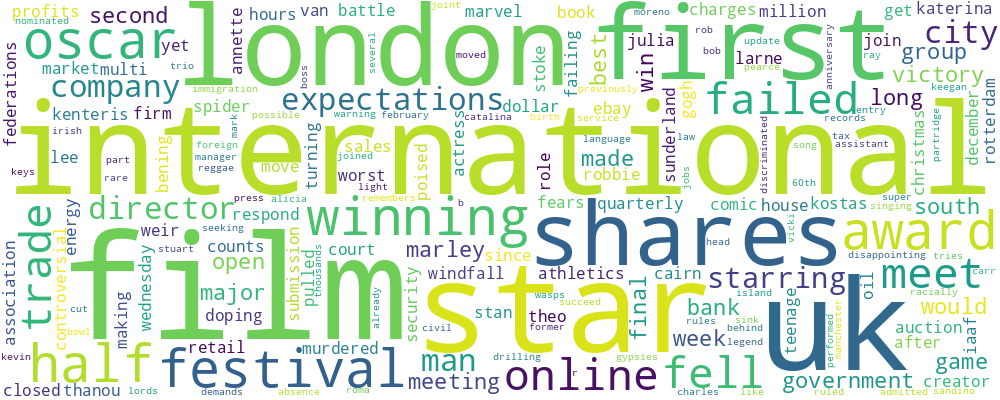

Wordcloud for category #1


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


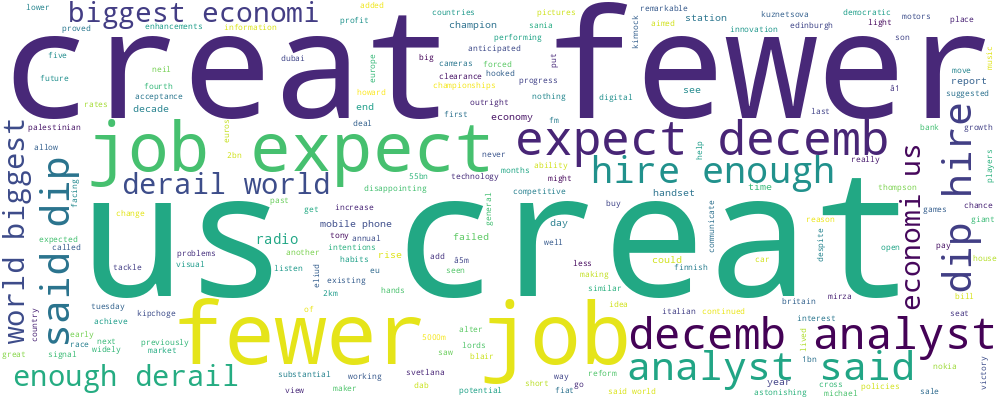

Wordcloud for category #2


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


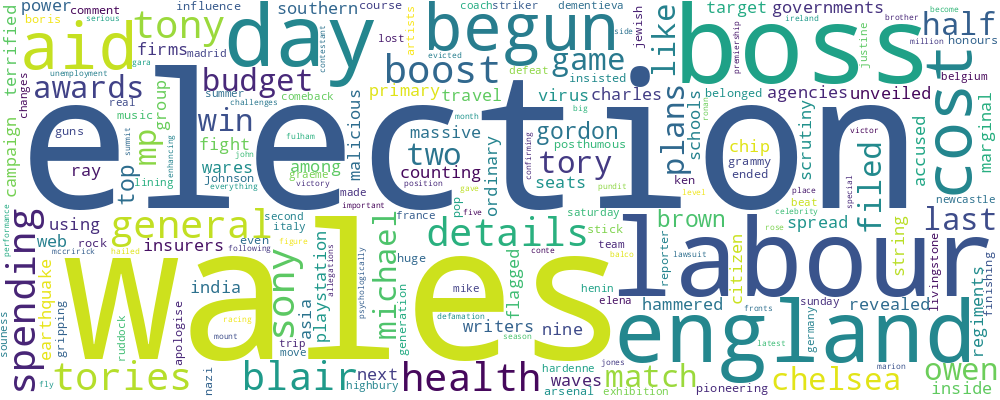

Wordcloud for category #3


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


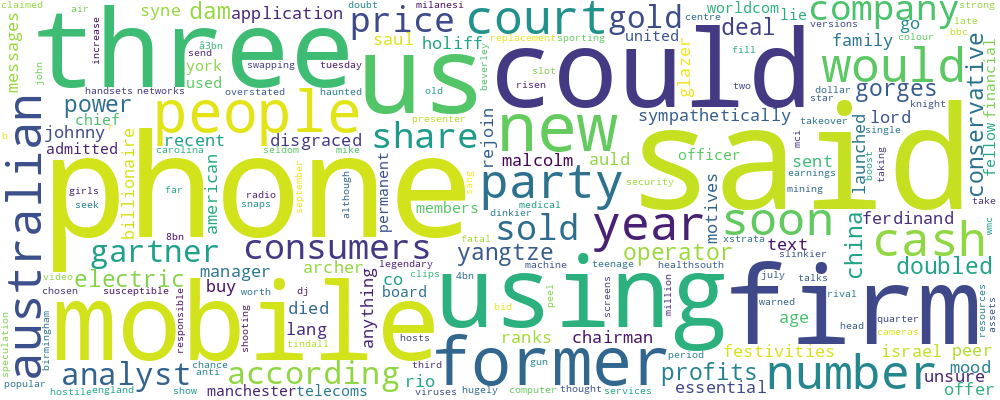

Wordcloud for category #4


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


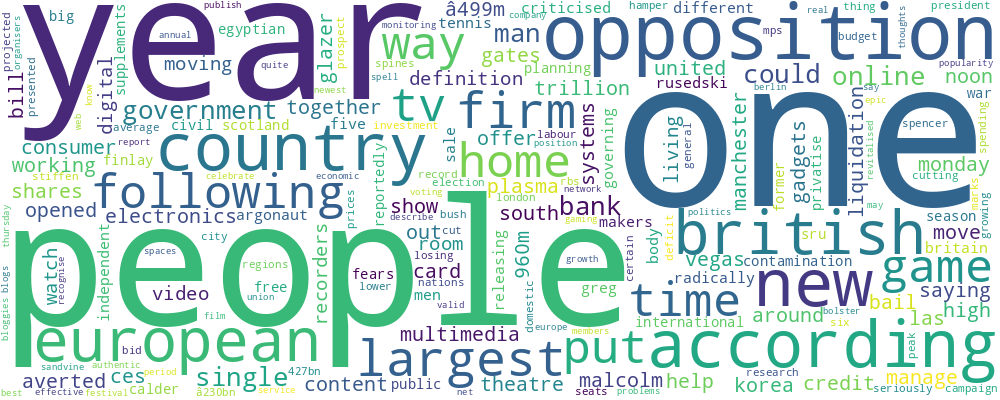

In [66]:
#visualisation of top words for the DBSCAN with text only
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=1000, height=400, stopwords=[])

for c in range(5):
    print("Wordcloud for category #{}".format(c))
    sentence = " ".join(df['Text'][df['Cluster 4'] == c])
    tokens = nltk.word_tokenize(sentence)
    pos_tagged_tokens = nltk.pos_tag(tokens)
    list_of_verbs = []
    for i in range(len(pos_tagged_tokens)):
        if pos_tagged_tokens[i][1] == 'VBZ':
            list_of_verbs.append(pos_tagged_tokens[i][0])
    
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(list_of_verbs)
    
    filtered_sentence = [w for w in tokens if not w.lower() in stopwords]
    
    final_sentence = " ".join(filtered_sentence)
    display(wc.generate(final_sentence).to_image())